# Fall 2025 - Assignment 1

Electronic submission on ZoneCours no later than **October 17 at 11:55 PM** of:

* This Jupyter notebook (.ipynb) as the report, after adding your answers.
* All .py files necessary to run the notebook

The report must:

* be in .ipynb format (points will be deducted for any other format).
* include the student ID number of all team members in the first cell (i.e., replace these instructions).
* answer the questions and discuss the results using tables, figures, and Markdown cells.

Grading rubric:

* **40%** Accuracy of results
* **25%** Complete and concise discussions (Markdown cells)
* **20%** Conciseness of the notebook (.ipynb with minimal code) and clarity of figures
* **15%** Code clarity (.py)

# Context

We are going to consider the most liquid options traded on Apple on two particular business days of 2020: January 17 and March 20. The next couple of code cells were used to generate the dataset by connecting to OptionMetrics. With `GENERATE = False`, they simply load the dataset as saved to disk.

In [ ]:
# The following import allow absolute imports scripts within the dorion_francois package
#import internal_script 

import datetime as dt
import os
import sys
import numpy as np
import pandas as pd
import pickle
import importlib

##############################################################################
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

In [2]:
def filters(options):
    """These filters were applied to the data"""
    # Options before maturity
    options = options.loc[options.date < options.exdate].reset_index()

    # Positive open interest
    options = options[options['open_interest'] > 0] 

    # Abs(delta) between 0.01 and 0.99
    options = options[(options['delta'].abs() >= 0.01) & (options['delta'].abs() <= 0.99)] 

    # Implied vol between 0.03 and 2
    options = options[(options['impl_volatility'] >= 0.03) & (options['impl_volatility'] <= 2)] 

    # Bid price is greater than 0.1 and less than ask price
    options = options[(options['best_offer'] > options['best_bid']) & (options['best_bid'] > 0.1)] 
    
    return options

GENERATE = False
if GENERATE:
    import dorion_francois.option_metrics as om    
    jan17 = om.get_option_data(101594, dt.date(2020,1,17))
    mar20 = om.get_option_data(101594, dt.date(2020,3,20))
    options = filters( pd.concat((jan17,mar20),axis=0) )
    with open('202510-assignment1.pkl','wb') as fh:
        # OptionMetrics 'strike_price' column is the strike x1000. We'll drop it to avoid confusion; use the 'strike' column
        pickle.dump(options.drop(columns=['strike_price']),fh)
else:
    with open('202510-assignment1.pkl','rb') as fh:
        options = pickle.load(fh)
options.describe()

,index,secid,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,...,option_price,DTM,YTM,risk_free,stock_price,stock_exdiv,implied_forward_price,implied_vol_bms,implied_vol_bid,implied_vol_ask
count,3041.000000,3041.0,3041.0,3041.0,3041.0,3041.0,3041.000000,3041.0,3041.0,3041.0,...,3041.0,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3041.000000,3039.000000,2907.000000,3041.000000
mean,1290.575469,101594.0,39.54265,41.070812,302.719171,1493.480434,0.486984,0.051175,0.004216,43.996647,...,40.306731,247.602105,0.678362,0.011057,267.849300,266.408353,268.266957,0.491364,0.463369,0.517211
std,588.418749,0.0,47.505847,48.379765,1413.149222,2810.188475,0.246677,0.573104,0.00421,39.878651,...,47.939597,256.838994,0.703668,0.005106,44.329611,44.126488,45.364910,0.240483,0.227888,0.264064
min,166.000000,101594.0,0.11,0.14,0.0,1.0,0.209335,-0.989916,0.00004,0.264909,...,0.13,7.000000,0.019178,0.004597,229.240000,226.093746,227.456884,0.209760,0.004413,0.211192
25%,805.000000,101594.0,3.85,4.75,0.0,76.0,0.308580,-0.332122,0.001665,13.6014,...,4.25,35.000000,0.095890,0.006167,229.240000,227.603325,228.595023,0.313801,0.290405,0.324194
50%,1334.000000,101594.0,20.05,21.5,14.0,383.0,0.407585,0.02422,0.003027,29.80537,...,20.8,154.000000,0.421918,0.008564,229.240000,229.240000,229.774853,0.414581,0.389198,0.437239
75%,1800.000000,101594.0,60.75,63.0,97.0,1594.0,0.593389,0.526664,0.005168,64.20898,...,61.75,455.000000,1.246575,0.016588,318.730000,317.145554,319.221626,0.603811,0.573138,0.637671
max,2345.000000,101594.0,271.0,275.5,29443.0,28015.0,1.998797,0.989859,0.042843,193.543,...,273.25,882.000000,2.416438,0.017424,318.730000,318.730000,325.069560,1.656574,1.601841,2.527934


# Question 1

Create a scatter plot with the risk-free rate (`100*options.risk_free`) against the time to maturity expressed in years (`options.YTM`). Discuss the figure. Given that the Black-Merton-Scholes economy assumes that the risk-free rate is constant, should one still account for the variation it illustrates if pricing options with the model? Why?

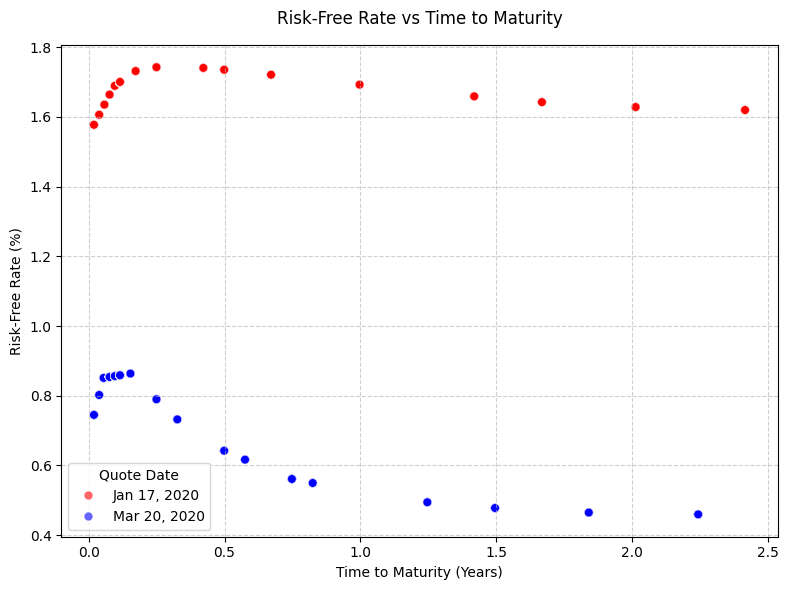

In [13]:
df = options[['YTM', 'risk_free', 'date']].dropna().copy()

# Label quote dates
df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y=100 * df['risk_free'],
    hue='quote_date',
    palette={'Jan 17, 2020': 'red', 'Mar 20, 2020': 'blue'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Risk-Free Rate (%)")
plt.title("Risk-Free Rate vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()

# Question 2
Similarly, scatter `options.stock - options.stock_exdiv`, where the former is the stock price and the latter accounts for the dividends **actually** paid over the life of the options.

Discuss the figure. Can we conclude that Apple changed its dividend policy between the two dates? Describe which variation of the Black-Merton-Scholes formula seen in class could be used to price the options on Apple if they were European options. Support your discussion with succinct mathematical expressions and/or derivations, in which you can focus on the calls without loss of generality.

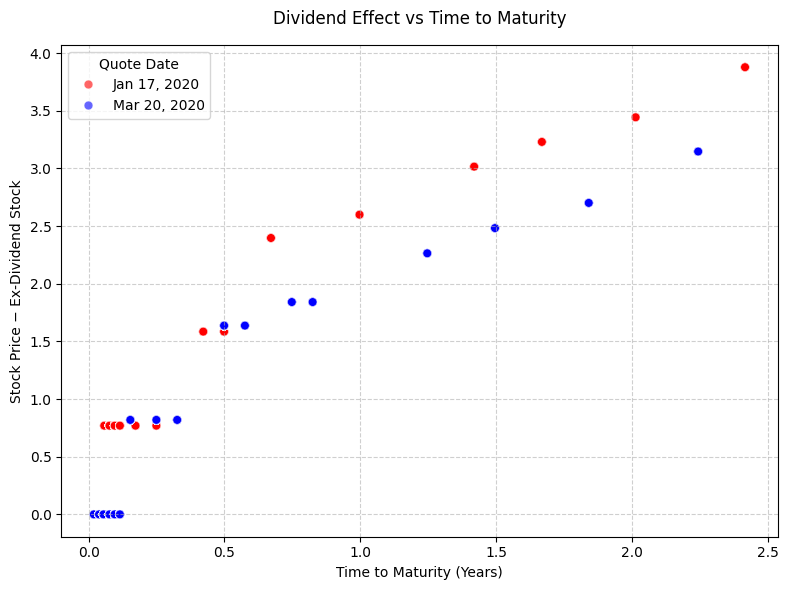

In [14]:
df = options[['YTM', 'stock_price', 'stock_exdiv', 'date']].dropna().copy()
df['div_eff'] = df['stock_price'] - df['stock_exdiv']

# Label quote dates
df['quote_date'] = pd.to_datetime(df['date']).dt.normalize().map({
    pd.Timestamp('2020-01-17'): 'Jan 17, 2020',
    pd.Timestamp('2020-03-20'): 'Mar 20, 2020'
})

df = df[df['quote_date'].notna()]

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='YTM',
    y='div_eff',
    hue='quote_date',
    palette={'Jan 17, 2020': 'red', 'Mar 20, 2020': 'blue'},
    alpha=0.6,
    s=40
)

plt.xlabel("Time to Maturity (Years)")
plt.ylabel("Stock Price − Ex-Dividend Stock")
plt.title("Dividend Effect vs Time to Maturity", pad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Quote Date")
plt.tight_layout()
plt.show()


# Question 3
Implement a function that inverts this variation of the BSM formula to obtain the BMS implied volatility for each of the options in the dataframe. Define moneyness as $M = K / \hat{S}_t$ and focus on out-of-the-money (OTM) options ($M \le 1$ puts, $M > 1$ calls). Create a dataframe `otm_options` containing only those options and add a column with the result of your IV calculation for each option therein.

In a 1x2 figure, scatter your results, with  on the x-axis, against a line plot for `implied_vol_bms`: In the left (right) panel, use options quoted on Jan 17 and expiring on Feb 14 (July 17), 2020, and options quoted on Mar 20 expiring on April 17 (Oct. 16), 2020. On each panel, you should thus have 2 lines with your results scattered atop them. Discuss this figure: how does the level and span (across moneyness) of the smiles vary, compare across maturities, etc. Given your discussion, can you suggest a better measure for moneyness? If you generate anew the previous figure using this alternate moneyness measure, how does it impact your analysis of the figure?

In [45]:
from scipy.stats import norm
from scipy.optimize import brentq

# Black–Scholes price
def bs_price(S, K, r, tau, sigma, cp):
    if sigma <= 0 or tau <= 0:
        intrinsic = max(0.0, (S - K) if cp == "C" else (K - S)) #forced to be added otherwise with get div 0
        return intrinsic
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    if cp == "C":
        return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    else:  # "P"
        return K * np.exp(-r * tau) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied vol
def implied_vol(price, S, K, r, tau, cp, vol_lo=1e-6, vol_hi=5.0):
    forward = S * np.exp(r * tau)
    intrinsic = max(0.0, (S - K) if cp == "C" else (K - S))
    upper_bound = S if cp == "C" else K * np.exp(-r * tau)
    if not (intrinsic <= price <= upper_bound + 1e-8):
        return np.nan 

    # Root
    def f(sig):
        return bs_price(S, K, r, tau, sig, cp) - price

    try:
        lo, hi = vol_lo, vol_hi
        flo, fhi = f(lo), f(hi)
        if flo * fhi > 0:
            for hi in (7.5, 10.0):
                if f(lo) * f(hi) <= 0:
                    break
            else:
                return np.nan
        return brentq(f, lo, hi, maxiter=200, xtol=1e-8)
    except Exception:
        return np.nan

# Compute IVs

options = options.copy()

# Moneyness
options["M"] = options["strike"] / options["stock_exdiv"]

# OTM mask
mask_otm = ((options["cp_flag"] == "P") & (options["M"] <= 1.0)) | \
           ((options["cp_flag"] == "C") & (options["M"] > 1.0))

otm_options = options.loc[mask_otm].copy()

# Compute IV per-row
def _row_iv(row):
    return implied_vol(
        price=row["option_price"],
        S=row["stock_exdiv"],
        K=row["strike"],
        r=row["risk_free"],
        tau=row["YTM"],
        cp=row["cp_flag"]
    )

otm_options["iv_bsm"] = otm_options.apply(_row_iv, axis=1)


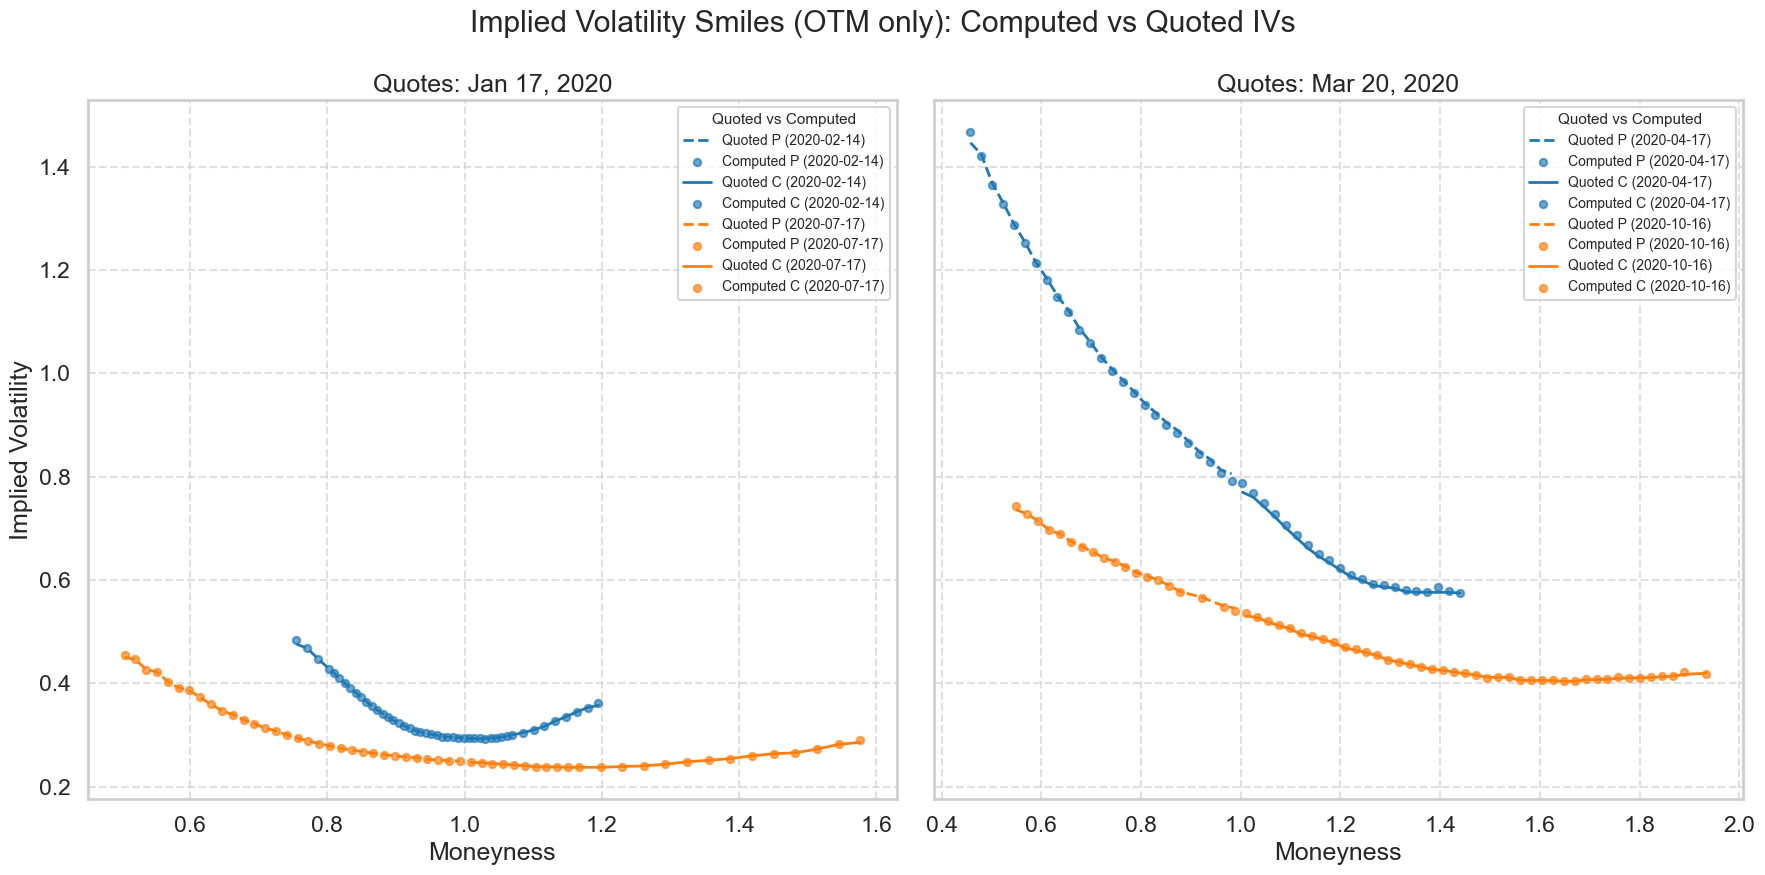

In [ ]:

QUOTE_LEFT  = pd.Timestamp("2020-01-17")
EXPS_LEFT   = [pd.Timestamp("2020-02-14"), pd.Timestamp("2020-07-17")]
QUOTE_RIGHT = pd.Timestamp("2020-03-20")
EXPS_RIGHT  = [pd.Timestamp("2020-04-17"), pd.Timestamp("2020-10-16")]

# reference IV 
iv_ref_col = next(c for c in ["implied_vol_bms","impl_volatility","impl_vol"] if c in options.columns)

opt = options.copy()
opt["date"]   = pd.to_datetime(opt["date"]).dt.tz_localize(None).dt.normalize()
opt["exdate"] = pd.to_datetime(opt["exdate"]).dt.tz_localize(None).dt.normalize()
opt["M"] = opt["strike"] / opt["stock_exdiv"]

# OTM mask 
mask_otm = ((opt["cp_flag"]=="P") & (opt["M"]<=1.0)) | ((opt["cp_flag"]=="C") & (opt["M"]>1.0))

# reference 
ref = opt.loc[mask_otm, ["date","exdate","cp_flag","M",iv_ref_col]].dropna().copy()

otm_options = otm_options.copy()
otm_options["date"]   = pd.to_datetime(otm_options["date"]).dt.tz_localize(None).dt.normalize()
otm_options["exdate"] = pd.to_datetime(otm_options["exdate"]).dt.tz_localize(None).dt.normalize()

# computed IVs 
mine = otm_options.loc[:, ["date","exdate","cp_flag","M","iv_bsm"]].dropna().copy()

# rolling median smoothing 
def smooth_by_M(df, ycol, win=3):
    d = df.sort_values("M").copy()
    if len(d) >= win:
        d[ycol] = d[ycol].rolling(win, center=True, min_periods=1).median()
    return d

#set up for figure
def plot_panel(ax, qdate, expiries, title):
    colors = sns.color_palette(n_colors=len(expiries))
    ls_map = {"P":"--", "C":"-"}  

    for i, exp in enumerate(expiries):
        for cp in ["P","C"]:
            r = ref[(ref["date"]==qdate) & (ref["exdate"]==exp) & (ref["cp_flag"]==cp)]
            m = mine[(mine["date"]==qdate) & (mine["exdate"]==exp) & (mine["cp_flag"]==cp)]

            if not r.empty:
                r = smooth_by_M(r, iv_ref_col, win=3)
                ax.plot(
                    r["M"], r[iv_ref_col],
                    ls_map[cp], color=colors[i], lw=2,
                    label=f"Quoted {cp} ({exp.date()})"
                )

            if not m.empty:
                m = m.sort_values("M")
                ax.scatter(
                    m["M"], m["iv_bsm"],
                    color=colors[i], s=28, alpha=0.65,
                    label=f"Computed {cp} ({exp.date()})"
                )

    ax.set_title(title)
    ax.set_xlabel(r"Moneyness")
    ax.grid(True, linestyle="--", alpha=0.6)

sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(18, 9), sharey=True)

plot_panel(axes[0], QUOTE_LEFT,  EXPS_LEFT,  "Quotes: Jan 17, 2020")
plot_panel(axes[1], QUOTE_RIGHT, EXPS_RIGHT, "Quotes: Mar 20, 2020")

axes[0].set_ylabel("Implied Volatility")

for ax in axes:
    ax.legend(
        title="Quoted vs Computed",
        frameon=True,
        fontsize=10,
        title_fontsize=11,
        loc="upper right",
        ncol=1
    )

fig.suptitle("Implied Volatility Smiles (OTM only): Computed vs Quoted IVs")
fig.tight_layout()
plt.show()


# Question 4

Consider the same OTM options as in the previous question. We now want to scatter
\begin{equation}
    100 \left(\frac{ \text{'impl\_volatility'} }{ \text{'implied\_vol\_bms'} } - 1\right)
\end{equation}
against moneyness (the version you feel most comfortable with). The 'impl_volatility' column provides an implied volatility measure as computed by the data provider using a proprietary algorithm. How should the y-axis be interpreted? Are the magnitudes relatively large or small? Would we obtain the same result comparing CRR and BMS implied volatilities for the in-the-money (ITM) options?

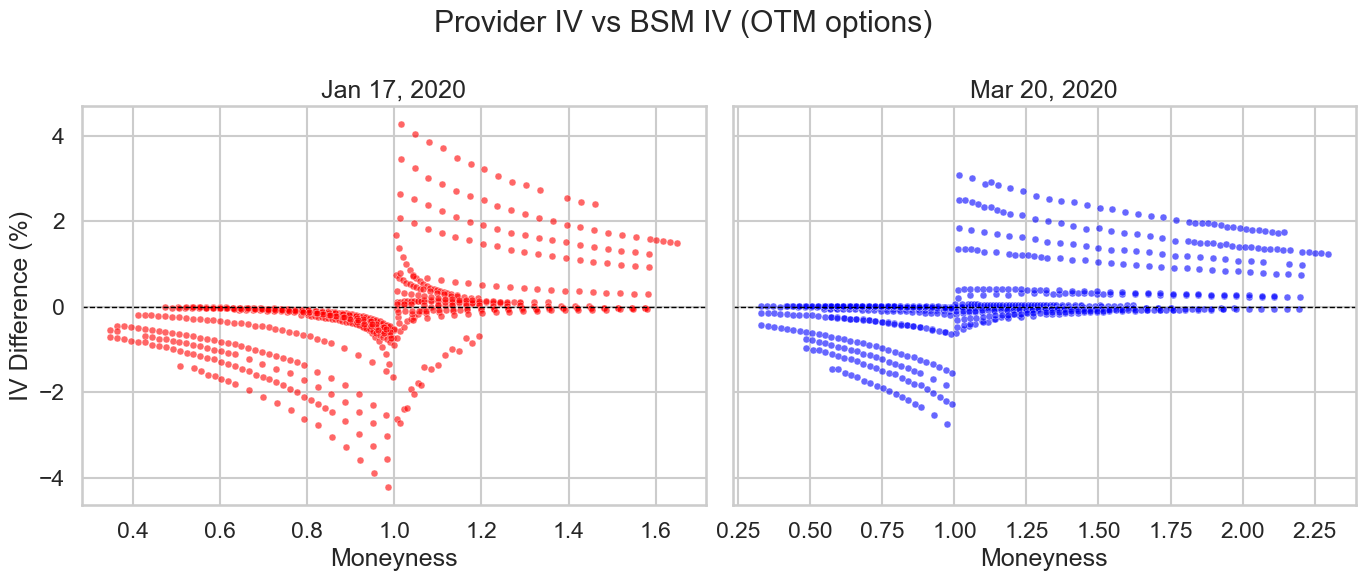

In [ ]:
# set up for dates
def _norm_dates(df):
    df = df.copy()
    for c in ["date", "exdate"]:
        df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()
    return df

opts = _norm_dates(options)
otm  = _norm_dates(otm_options)   # contains iv_bsm

# merge ivs
keys = ["date", "exdate", "cp_flag", "strike"]
df = (
    otm[keys + ["stock_exdiv", "iv_bsm"]]
    .merge(opts[keys + ["impl_volatility"]], on=keys, how="left")
    .dropna(subset=["iv_bsm", "impl_volatility", "stock_exdiv"])
)

# same moneyness
df["moneyness"] = df["strike"] / df["stock_exdiv"]

# OTM filter
df = df[((df["cp_flag"] == "P") & (df["moneyness"] <= 1.0)) |
        ((df["cp_flag"] == "C") & (df["moneyness"] > 1.0))]

df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_bsm"] - 1)

df_jan17 = df[df['date'] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df['date'] == pd.Timestamp("2020-03-20")].copy()

# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# --- Jan 17, 2020 ---
sns.scatterplot(
    data=df_jan17,
    x="moneyness",
    y="iv_diff_pct",
    alpha=0.6,
    s=25,
    ax=axes[0],
    color="red"
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Moneyness")
axes[0].set_ylabel("IV Difference (%)")

# --- Mar 20, 2020 ---
sns.scatterplot(
    data=df_mar20,
    x="moneyness",
    y="iv_diff_pct",
    alpha=0.6,
    s=25,
    ax=axes[1],
    color="blue"
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Moneyness")
axes[1].set_ylabel("")

fig.suptitle("Provider IV vs BSM IV (OTM options)")

plt.tight_layout()
plt.show()

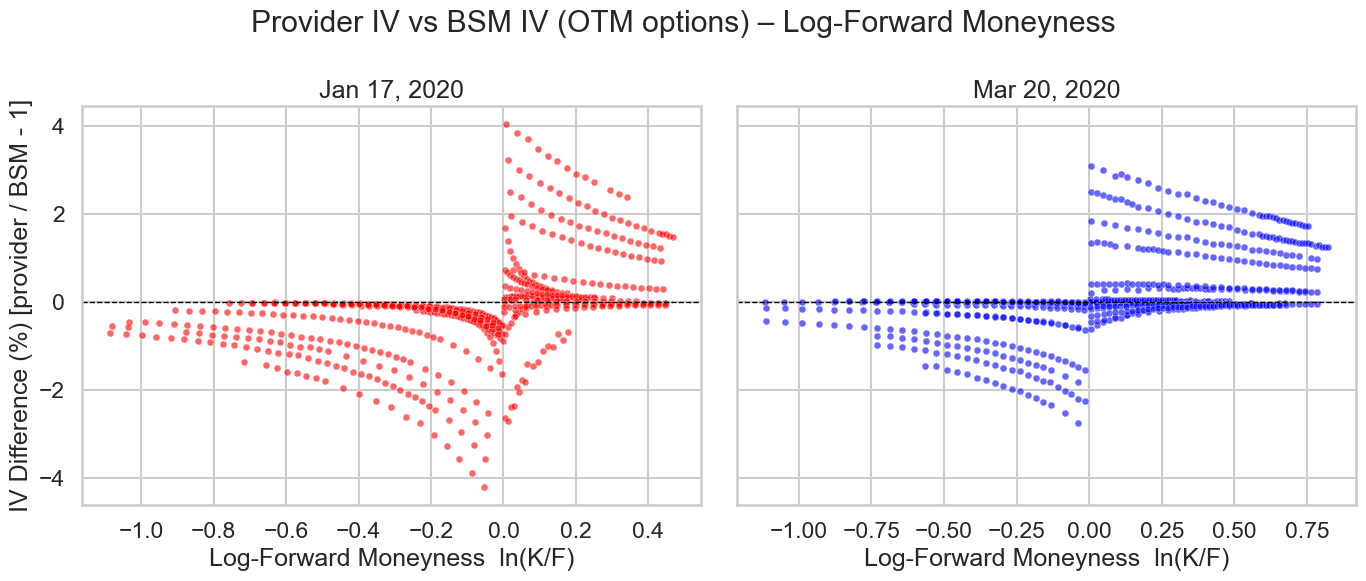

In [46]:

def _norm_dates(df):
    df = df.copy()
    for c in ["date", "exdate"]:
        df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()
    return df

opts = _norm_dates(options)
otm  = _norm_dates(otm_options) 

keys = ["date", "exdate", "cp_flag", "strike"]
df = (
    otm[keys + ["stock_exdiv", "iv_bsm", "risk_free", "YTM"]]
    .merge(opts[keys + ["impl_volatility"]], on=keys, how="left")
    .dropna(subset=["iv_bsm", "impl_volatility", "stock_exdiv", "risk_free", "YTM"])
)

df["F"] = df["stock_exdiv"] * np.exp(df["risk_free"] * df["YTM"])
df["log_fwd_moneyness"] = np.log(df["strike"] / df["F"])

df = df[((df["cp_flag"] == "C") & (df["log_fwd_moneyness"] > 0.0)) |
        ((df["cp_flag"] == "P") & (df["log_fwd_moneyness"] < 0.0))]

# % difference
df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_bsm"] - 1)

df_jan17 = df[df["date"] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df["date"] == pd.Timestamp("2020-03-20")].copy()

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

sns.scatterplot(
    data=df_jan17, x="log_fwd_moneyness", y="iv_diff_pct",
    alpha=0.6, s=25, ax=axes[0], color="red"
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Log-Forward Moneyness  ln(K/F)")
axes[0].set_ylabel("IV Difference (%) [provider / BSM - 1]")

sns.scatterplot(
    data=df_mar20, x="log_fwd_moneyness", y="iv_diff_pct",
    alpha=0.6, s=25, ax=axes[1], color="blue"
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Log-Forward Moneyness  ln(K/F)")
axes[1].set_ylabel("")

fig.suptitle("Provider IV vs BSM IV (OTM options) – Log-Forward Moneyness")
plt.tight_layout()
plt.show()


# Question 5

Convert the present value of dividends corresponding to each option into an approximate convenience yield. Implement the CRR tree with diviended yield ($y$) and obtain your own CRR-implied volatility; use a number of time steps equal to 5 times the days to maturity ('DTM').  Compare it with the 'impl_volatility' provided in the dataframe. In particular, does this yield better approximations than the ones in 'implied_vol_bms'? Support your answer with some summary statistics and a figure.

In [26]:
from scipy.optimize import brentq

# --- CRR with dividend yield (stable) ---
def crr_price_stable(S, K, T, r, y, sigma, option_type="C", steps=2000, max_steps=600):
    if T <= 0:
        # immediate expiry -> intrinsic
        return max(0.0, (S-K) if option_type=="C" else (K-S))

    # cap steps to avoid overflow / O(N^2) blowup
    N = int(min(max(1, steps), max_steps))
    dt = T / N
    if sigma <= 0:
        # practically zero vol: discounted forward intrinsic
        f = S*np.exp((r-y)*T)
        return max(0.0, (f - K)*np.exp(-r*T)) if option_type=="C" else max(0.0, (K - f)*np.exp(-r*T))

    u = np.exp(sigma*np.sqrt(dt))
    d = 1.0 / u
    # risk-neutral probability under dividend yield
    p = (np.exp((r - y) * dt) - d) / (u - d)
    # numerically clip p
    p = float(np.clip(p, 1e-12, 1-1e-12))
    disc = np.exp(-r * dt)

    # --- terminal stock prices computed iteratively to avoid overflow ---
    # start at the "all downs" node: S * d^N (compute via logs to avoid under/overflow)
    log_S0 = np.log(S) + N*np.log(d)
    S_k = np.exp(log_S0)

    payoff = np.empty(N+1, dtype=np.float64)
    if option_type == "C":
        for k in range(N+1):
            payoff[k] = max(S_k - K, 0.0)
            S_k *= (u/d)  # move to next node
    else:
        for k in range(N+1):
            payoff[k] = max(K - S_k, 0.0)
            S_k *= (u/d)

    # backward induction
    for _ in range(N):
        payoff = disc * (p*payoff[1:] + (1.0 - p)*payoff[:-1])

    return float(payoff[0])

def implied_vol_crr_stable(S, K, T, r, y, market_price, option_type, steps, max_steps=600):
    # bracketed root: avoid bad bounds with a quick check
    def f(sig):
        return crr_price_stable(S, K, T, r, y, sig, option_type, steps=steps, max_steps=max_steps) - market_price
    try:
        # widen upper bound if necessary
        lo, hi = 1e-6, 3.0
        flo, fhi = f(lo), f(hi)
        if flo * fhi > 0:
            for hi_try in (5.0, 8.0, 12.0):
                if f(lo)*f(hi_try) <= 0:
                    hi = hi_try
                    break
            else:
                return np.nan
        return brentq(f, lo, hi, xtol=1e-8, maxiter=200)
    except Exception:
        return np.nan

# ----- Build CRR-implied vols on your dataframe (robustly) -----
# Steps rule from prompt: N = 5 * DTM, but we'll cap at 600 to stay stable/fast.
def rows_iv_crr(df):
    iv = pd.Series(index=df.index, dtype=float)
    for idx, r in df.iterrows():
        S   = float(r["stock_price"])
        K   = float(r["strike"])
        T   = float(r["YTM"])
        rr  = float(r["risk_free"])
        y   = 0.0 if T <= 0 or r["stock_exdiv"] <= 0 else max(0.0, (1.0/T)*np.log(r["stock_price"]/r["stock_exdiv"]))
        steps = int(max(1, 5 * float(r["DTM"])))
        steps = min(steps, 600)
        cp   = "C" if str(r["cp_flag"]).upper().startswith("C") else "P"
        iv.loc[idx] = implied_vol_crr_stable(S, K, T, rr, y, float(r["option_price"]), cp, steps)
    return iv


In [27]:
# Compute CRR IVs
options = options.copy()
options["iv_crr"] = rows_iv_crr(options)

# Compare to provider IV safely
valid = options[["strike","stock_exdiv","impl_volatility","iv_crr"]].dropna().copy()
valid["moneyness"] = valid["strike"] / valid["stock_exdiv"]
valid["iv_diff_pct"] = 100 * (valid["impl_volatility"] / valid["iv_crr"] - 1)


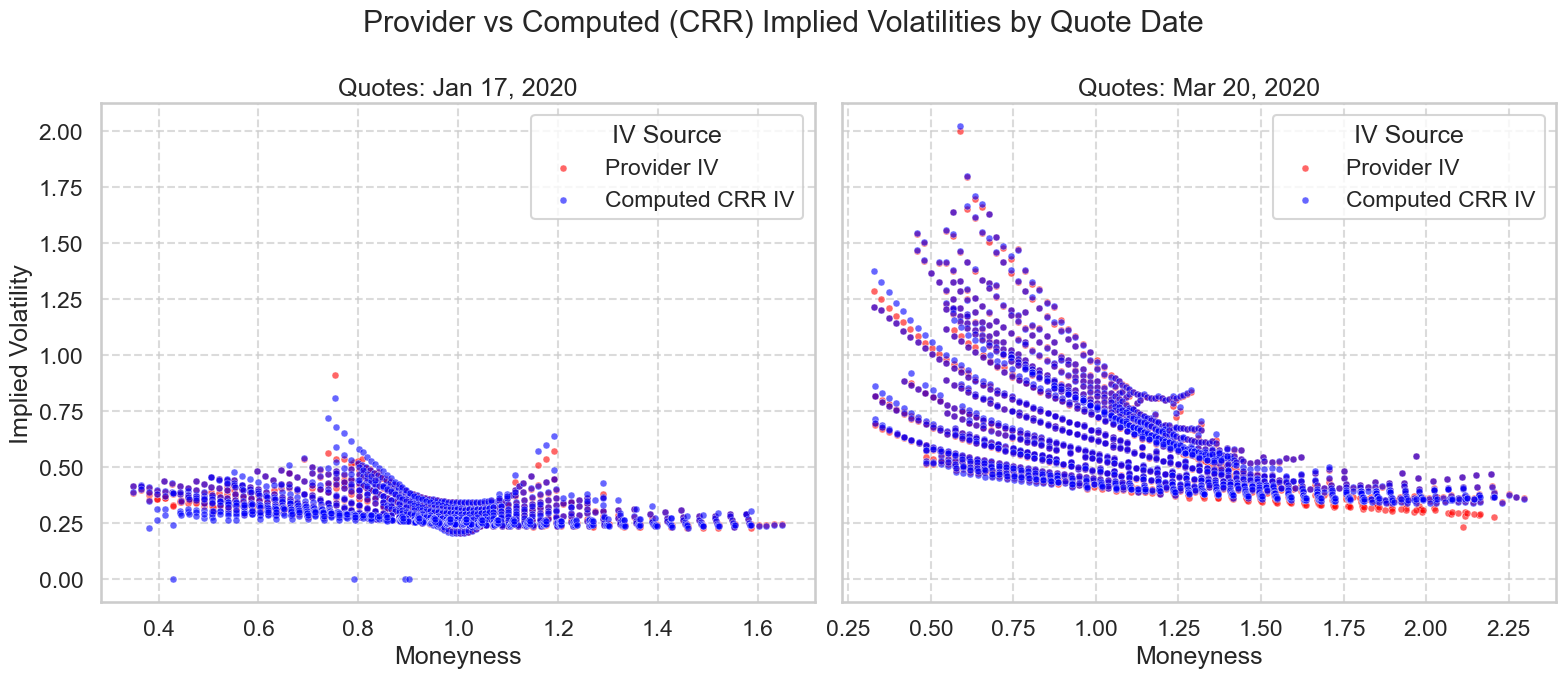

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---- prepare data ----
valid = options[["date", "strike", "stock_exdiv", "impl_volatility", "iv_crr"]].dropna().copy()
valid["date"] = pd.to_datetime(valid["date"]).dt.normalize()
valid["moneyness"] = valid["strike"] / valid["stock_exdiv"]
valid["quote_date"] = valid["date"].map({
    pd.Timestamp("2020-01-17"): "Jan 17, 2020",
    pd.Timestamp("2020-03-20"): "Mar 20, 2020"
})

# keep only known quote dates
valid = valid[valid["quote_date"].notna()].copy()

# ---- figure layout ----
sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

palette = {"Provider IV": "red", "CRR IV": "blue"}

# ---- plot each date ----
for i, (qdate, ax) in enumerate(zip(valid["quote_date"].unique(), axes)):
    sub = valid[valid["quote_date"] == qdate].copy()

    sns.scatterplot(
        data=sub, x="moneyness", y="impl_volatility",
        ax=ax, color=palette["Provider IV"], label="Provider IV",
        alpha=0.6, s=25
    )
    sns.scatterplot(
        data=sub, x="moneyness", y="iv_crr",
        ax=ax, color=palette["CRR IV"], label="Computed CRR IV",
        alpha=0.6, s=25
    )

    ax.set_title(f"Quotes: {qdate}")
    ax.set_xlabel("Moneyness")
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(title="IV Source")

axes[0].set_ylabel("Implied Volatility")
fig.suptitle("Provider vs Computed (CRR) Implied Volatilities by Quote Date")
fig.tight_layout()
plt.show()


Overall error metrics (lower is better):
                      MAE      RMSE    MAPE_%      Bias
CRR vs Provider  0.008904  0.022722  2.365742  0.003433
BMS vs Provider  0.009509  0.023856  2.062676  0.005209

By quote date:
                                   MAE      RMSE    MAPE_%      Bias
Jan 17, 2020 BMS vs Provider  0.006633  0.015347  1.990902  0.005756
             CRR vs Provider  0.011369  0.030349  3.364295  0.001993
Mar 20, 2020 BMS vs Provider  0.011693  0.028680  2.117203  0.004793
             CRR vs Provider  0.007032  0.014448  1.607141  0.004528


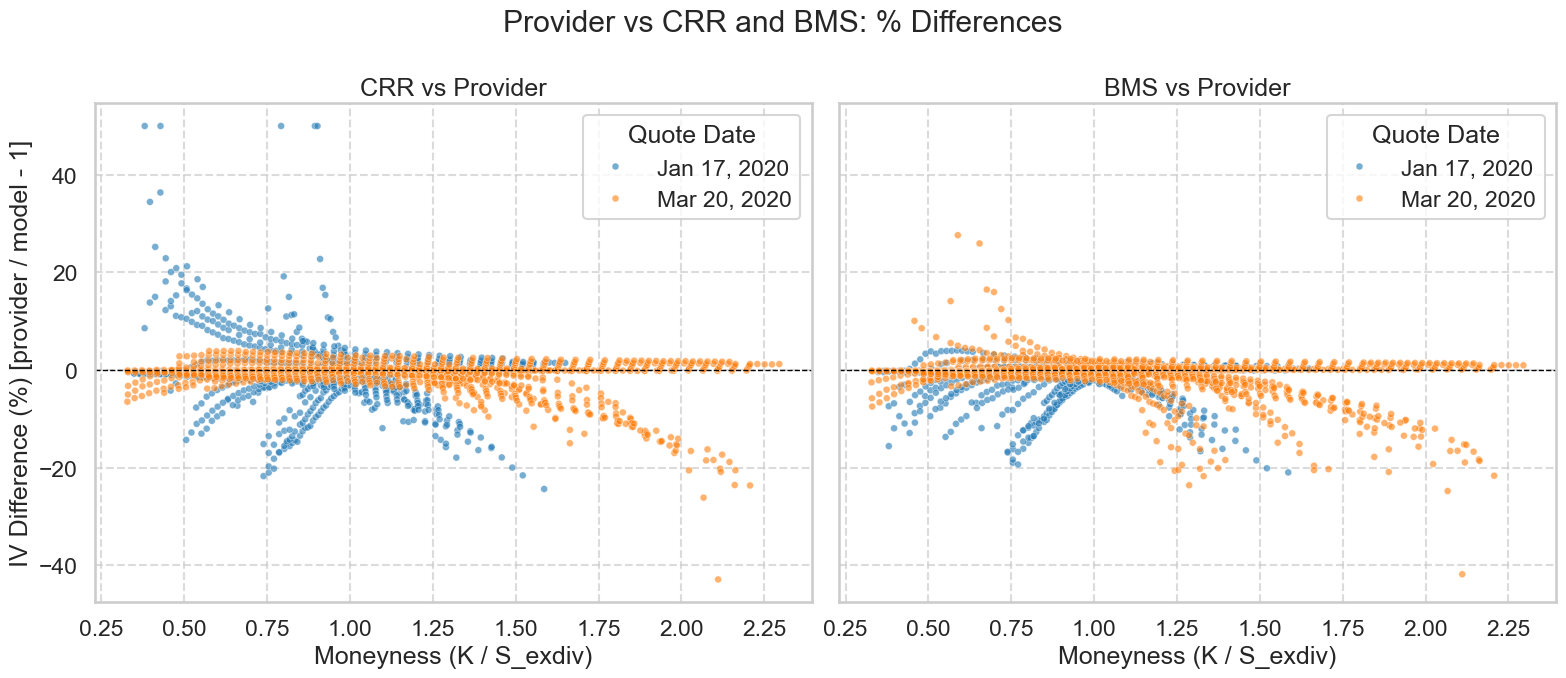

In [36]:
# ---- Summary stats: does CRR (with y) beat implied_vol_bms vs provider? ----
cols_needed = ["impl_volatility", "iv_crr", "implied_vol_bms", "date", "strike", "stock_exdiv"]
have_bms = "implied_vol_bms" in options.columns
cmp = options[cols_needed].dropna() if have_bms else options[["impl_volatility", "iv_crr", "date", "strike", "stock_exdiv"]].dropna().copy()

def metrics(y_true, y_pred):
    err = y_pred - y_true
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    mape = 100*np.mean(np.abs(err / np.where(y_true==0, np.nan, y_true)))
    bias = np.mean(err)
    return pd.Series({"MAE": mae, "RMSE": rmse, "MAPE_%": mape, "Bias": bias})

stats = []
stats.append(("CRR vs Provider", metrics(cmp["impl_volatility"].values, cmp["iv_crr"].values)))
if have_bms:
    stats.append(("BMS vs Provider", metrics(cmp["impl_volatility"].values, cmp["implied_vol_bms"].values)))

summary = pd.concat([s.rename(idx) for idx, s in stats], axis=1).T
print("Overall error metrics (lower is better):")
print(summary)

# Optional: by quote date as well
cmp["date"] = pd.to_datetime(cmp["date"]).dt.normalize()
dates_map = {pd.Timestamp("2020-01-17"): "Jan 17, 2020", pd.Timestamp("2020-03-20"): "Mar 20, 2020"}
cmp["quote_date"] = cmp["date"].map(dates_map)

bydate = []
for qd, sub in cmp.groupby("quote_date"):
    if qd is None: 
        continue
    row = metrics(sub["impl_volatility"].values, sub["iv_crr"].values)
    row.name = (qd, "CRR vs Provider")
    if have_bms:
        row2 = metrics(sub["impl_volatility"].values, sub["implied_vol_bms"].values)
        row2.name = (qd, "BMS vs Provider")
        bydate.append(row2)
    bydate.append(row)
bydate = pd.DataFrame(bydate)
if not bydate.empty:
    print("\nBy quote date:")
    print(bydate)

# ---- Figure already in Block 2 (Provider vs CRR IVs by quote date) ----
# You can keep that. If you also want a % difference panel for CRR (and BMS), add:

if have_bms:
    cmp["moneyness"] = cmp["strike"] / cmp["stock_exdiv"]
    cmp["crr_diff_%"] = 100*(cmp["impl_volatility"]/cmp["iv_crr"] - 1)
    cmp["bms_diff_%"] = 100*(cmp["impl_volatility"]/cmp["implied_vol_bms"] - 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
    for ax, (label, col) in zip(axes, [("CRR vs Provider", "crr_diff_%"),
                                       ("BMS vs Provider", "bms_diff_%")]):
        sub = cmp.dropna(subset=[col]).copy()
        sns.scatterplot(data=sub, x="moneyness", y=sub[col].clip(-50, 50),
                        hue="quote_date", palette="tab10", alpha=0.6, s=25, ax=ax)
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_title(label)
        ax.set_xlabel("Moneyness (K / S_exdiv)")
        ax.set_ylabel("IV Difference (%) [provider / model - 1]")
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.legend_.set_title("Quote Date")
    fig.suptitle("Provider vs CRR and BMS: % Differences")
    plt.tight_layout()
    plt.show()


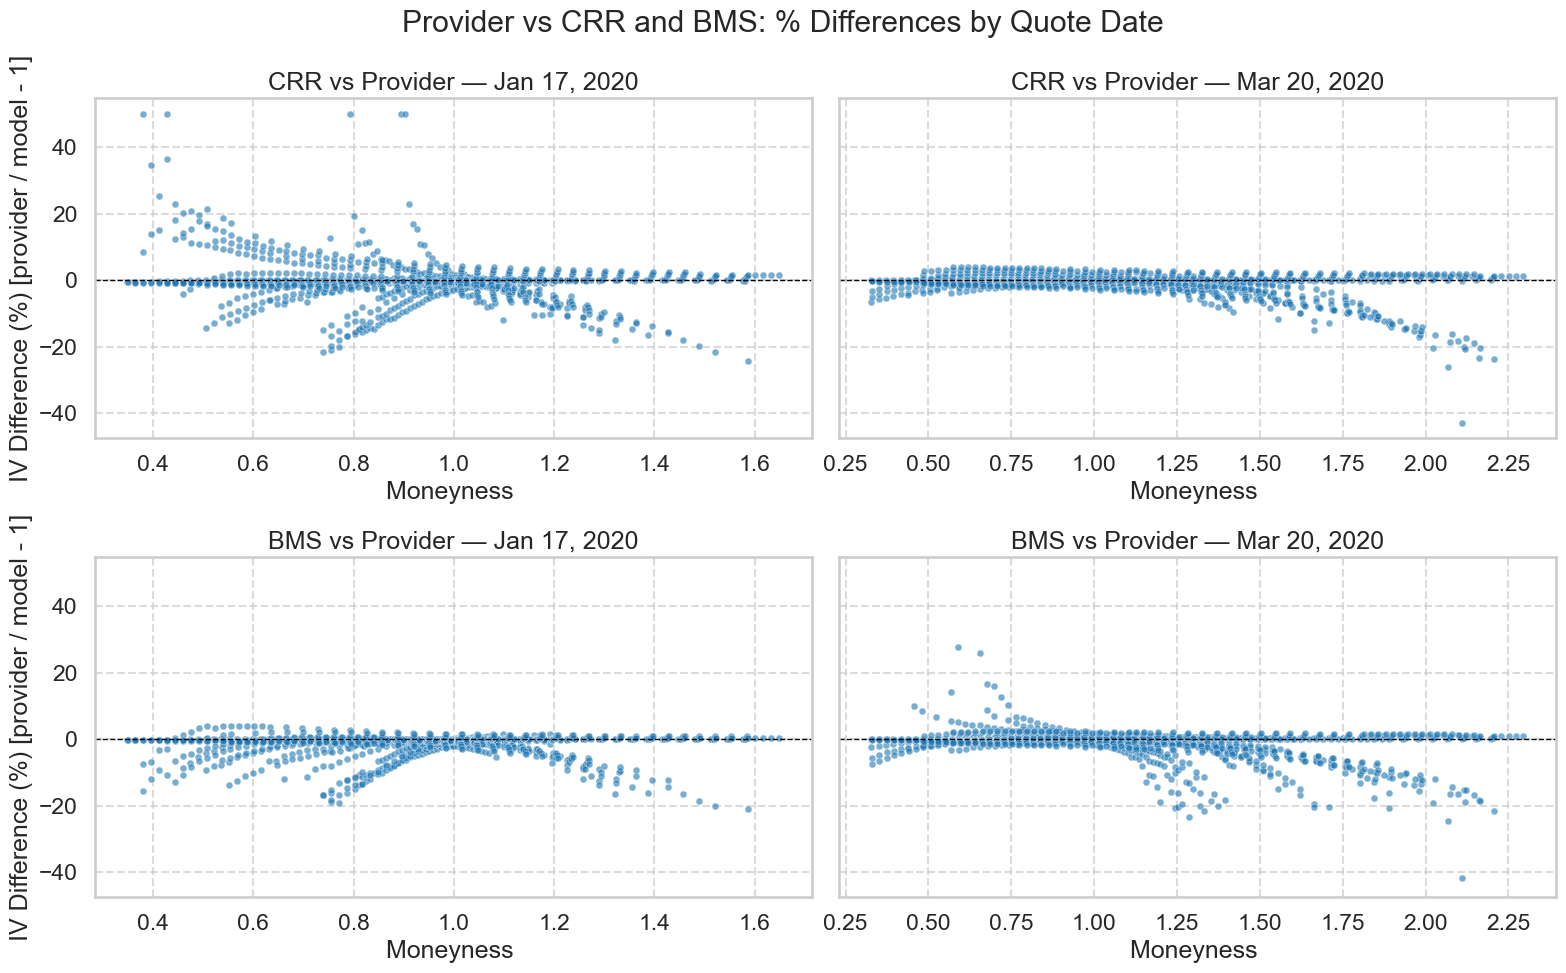

In [52]:
if have_bms:
    # Ensure helper cols exist
    cmp["date"] = pd.to_datetime(cmp["date"]).dt.normalize()
    dates_map = {pd.Timestamp("2020-01-17"): "Jan 17, 2020",
                 pd.Timestamp("2020-03-20"): "Mar 20, 2020"}
    cmp["quote_date"] = cmp["date"].map(dates_map)
    cmp["moneyness"] = cmp["strike"] / cmp["stock_exdiv"]
    cmp["crr_diff_%"] = 100*(cmp["impl_volatility"]/cmp["iv_crr"] - 1)
    cmp["bms_diff_%"] = 100*(cmp["impl_volatility"]/cmp["implied_vol_bms"] - 1)

    # clip for readability
    cmp["crr_diff_clip"] = cmp["crr_diff_%"].clip(-50, 50)
    cmp["bms_diff_clip"] = cmp["bms_diff_%"].clip(-50, 50)

    # Plot 2×2: columns = quote dates, rows = model (CRR top, BMS bottom)
    sns.set_context("talk"); sns.set_style("whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

    panels = [
        ("CRR vs Provider", "crr_diff_clip", "Jan 17, 2020", 0, 0),
        ("CRR vs Provider", "crr_diff_clip", "Mar 20, 2020", 0, 1),
        ("BMS vs Provider", "bms_diff_clip", "Jan 17, 2020", 1, 0),
        ("BMS vs Provider", "bms_diff_clip", "Mar 20, 2020", 1, 1),
    ]

    # If you want hue by expiration, keep hue='exdate'; otherwise set hue=None
    use_hue = "exdate" in cmp.columns

    for title, ycol, qlabel, r, c in panels:
        ax = axes[r, c]
        sub = cmp[(cmp["quote_date"] == qlabel) & cmp[ycol].notna()].copy()
        sns.scatterplot(
            data=sub,
            x="moneyness", y=ycol,
            hue=("exdate" if use_hue else None),
            palette=("tab10" if use_hue else None),
            alpha=0.6, s=25, ax=ax, legend=use_hue
        )
        ax.axhline(0, color="black", linestyle="--", linewidth=1)
        ax.set_title(f"{title} — {qlabel}")
        ax.set_xlabel("Moneyness ")
        ax.set_ylabel("IV Difference (%) [provider / model - 1]" if c == 0 else "")
        ax.grid(True, linestyle="--", alpha=0.7)
        if not use_hue and ax.legend_:
            ax.legend_.remove()

    # One shared legend if hue by expiration
    if use_hue:
        handles, labels = axes[0,1].get_legend_handles_labels()
        fig.legend(handles, labels, title="Expiration", loc="upper center", ncol=4, frameon=True)

    fig.suptitle("Provider vs CRR and BMS: % Differences by Quote Date")
    plt.tight_layout()
    plt.show()
else:
    print("implied_vol_bms not found — cannot create 2×2 CRR/BMS comparison.")


In [54]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq

# --- CRR with dividend yield (stable) ---
def crr_price_stable(S, K, T, r, y, sigma, option_type="C", steps=2000, max_steps=600):
    if T <= 0:
        # immediate expiry -> intrinsic
        return max(0.0, (S-K) if option_type=="C" else (K-S))

    # cap steps to avoid overflow / O(N^2) blowup
    N = int(min(max(1, steps), max_steps))
    dt = T / N
    if sigma <= 0:
        # practically zero vol: discounted forward intrinsic
        f = S*np.exp((r-y)*T)
        return max(0.0, (f - K)*np.exp(-r*T)) if option_type=="C" else max(0.0, (K - f)*np.exp(-r*T))

    u = np.exp(sigma*np.sqrt(dt))
    d = 1.0 / u
    # risk-neutral probability under dividend yield
    p = (np.exp((r - y) * dt) - d) / (u - d)
    # numerically clip p
    p = float(np.clip(p, 1e-12, 1-1e-12))
    disc = np.exp(-r * dt)

    # --- terminal stock prices computed iteratively to avoid overflow ---
    # start at the "all downs" node: S * d^N (compute via logs to avoid under/overflow)
    log_S0 = np.log(S) + N*np.log(d)
    S_k = np.exp(log_S0)

    payoff = np.empty(N+1, dtype=np.float64)
    if option_type == "C":
        for k in range(N+1):
            payoff[k] = max(S_k - K, 0.0)
            S_k *= (u/d)  # move to next node
    else:
        for k in range(N+1):
            payoff[k] = max(K - S_k, 0.0)
            S_k *= (u/d)

    # backward induction
    for _ in range(N):
        payoff = disc * (p*payoff[1:] + (1.0 - p)*payoff[:-1])

    return float(payoff[0])

def implied_vol_crr_stable(S, K, T, r, y, market_price, option_type, steps, max_steps=600):
    # bracketed root: avoid bad bounds with a quick check
    def f(sig):
        return crr_price_stable(S, K, T, r, y, sig, option_type, steps=steps, max_steps=max_steps) - market_price
    try:
        # widen upper bound if necessary
        lo, hi = 1e-6, 3.0
        flo, fhi = f(lo), f(hi)
        if flo * fhi > 0:
            for hi_try in (5.0, 8.0, 12.0):
                if f(lo)*f(hi_try) <= 0:
                    hi = hi_try
                    break
            else:
                return np.nan
        return brentq(f, lo, hi, xtol=1e-8, maxiter=200)
    except Exception:
        return np.nan

# ----- Build CRR-implied vols on your dataframe (robustly) -----
# Steps rule from prompt: N = 5 * DTM, but we'll cap at 600 to stay stable/fast.
def rows_iv_crr(df):
    iv = pd.Series(index=df.index, dtype=float)
    for idx, r in df.iterrows():
        S   = float(r["stock_price"])
        K   = float(r["strike"])
        T   = float(r["YTM"])
        rr  = float(r["risk_free"])
        y   = 0.0 if T <= 0 or r["stock_exdiv"] <= 0 else max(0.0, (1.0/T)*np.log(r["stock_price"]/r["stock_exdiv"]))
        steps = int(max(1, 5 * float(r["DTM"])))
        steps = min(steps, 600)
        cp   = "C" if str(r["cp_flag"]).upper().startswith("C") else "P"
        iv.loc[idx] = implied_vol_crr_stable(S, K, T, rr, y, float(r["option_price"]), cp, steps)
    return iv


In [55]:
# Compute CRR IVs
options = options.copy()
options["iv_crr"] = rows_iv_crr(options)

# Compare to provider IV safely
valid = options[["strike","stock_exdiv","impl_volatility","iv_crr"]].dropna().copy()
valid["moneyness"] = valid["strike"] / valid["stock_exdiv"]
valid["iv_diff_pct"] = 100 * (valid["impl_volatility"] / valid["iv_crr"] - 1)

print(valid["iv_diff_pct"].describe())

count      3041.000000
mean        143.991724
std        4186.471880
min         -42.853372
25%          -1.128996
50%          -0.156655
75%           0.096498
max      147333.513689
Name: iv_diff_pct, dtype: float64


In [ ]:
# Prep: compute moneyness and % diff (clip extremes for readability)
df = options.copy()
df["moneyness"]   = df["strike"] / df["stock_exdiv"]
df["iv_diff_pct"] = 100 * (df["impl_volatility"] / df["iv_crr"] - 1)
df = df.dropna(subset=["moneyness", "iv_diff_pct", "date", "exdate"])

# (Optional) keep only OTM, to match previous questions
df = df[((df["cp_flag"]=="P") & (df["moneyness"]<=1.0)) |
        ((df["cp_flag"]=="C") & (df["moneyness"]>1.0))]

# Normalize dates so comparisons work
for c in ["date", "exdate"]:
    df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()

# Split by quote date
df_jan17 = df[df["date"] == pd.Timestamp("2020-01-17")].copy()
df_mar20 = df[df["date"] == pd.Timestamp("2020-03-20")].copy()

# Clip y for clearer y-scale (adjust if you want)
df_jan17["iv_diff_pct_clip"] = df_jan17["iv_diff_pct"].clip(-50, 50)
df_mar20["iv_diff_pct_clip"] = df_mar20["iv_diff_pct"].clip(-50, 50)

# ---- Plot: two panels, hue = expiration ----
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharey=True)

sns.scatterplot(
    data=df_jan17, x="moneyness", y="iv_diff_pct_clip",
    hue="exdate", palette="tab10", alpha=0.6, s=25, ax=axes[0]
)
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_title("Jan 17, 2020")
axes[0].set_xlabel("Moneyness")
axes[0].set_ylabel("IV Difference (%)  [impl_volatility / iv_crr - 1]")

sns.scatterplot(
    data=df_mar20, x="moneyness", y="iv_diff_pct_clip",
    hue="exdate", palette="tab10", alpha=0.6, s=25, ax=axes[1]
)
axes[1].axhline(0, color="black", linestyle="--", linewidth=1)
axes[1].set_title("Mar 20, 2020")
axes[1].set_xlabel("Moneyness")
axes[1].set_ylabel("")

axes[0].legend_.remove()
axes[1].legend_.remove()

# One shared legend for expirations
#handles, labels = axes[1].get_legend_handles_labels()
#fig.legend(handles, labels, title="Expiration", loc="upper center", ncol=3)

fig.suptitle("Provider IV vs CRR IV with Dividend Yield (OTM only)", y=1.03)
plt.tight_layout()
plt.show()

# Question 6

Given that the CRR tree should converge to the BMS model, the implied volatility obtained from American options prices using the CRR model can be used in the BMS closed-form formulas to obtain the price at which otherwise identical European options should be traded. Use the approximate convenience yield obtained in the previous question and <span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">the 'impl_volatility' field</span> provided with the data to do so. 

Plot the resulting value of early exercise options. (Hint: Because we are using an approximate convenience yield, some of these values could make little economic sense. Use your economic intuition to impose an upper bound on the artifical European prices.) Discuss the observed patterns.

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- Black-Scholes price with continuous dividend yield ---
def bsm_price(S, K, T, r, y, sigma, cp_flag):
    """European option price with dividend yield y"""
    if T <= 0 or sigma <= 0:
        return np.nan
    
    d1 = (np.log(S / K) + (r - y + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if cp_flag == "C":
        return S * np.exp(-y * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-y * T) * norm.cdf(-d1)

# --- Compute approximate European equivalent price ---
def compute_euro_equivalent(df):
    euro_prices = []
    
    for _, row in df.iterrows():
        S = row["stock_exdiv"]
        K = row["strike"]
        T = row["YTM"]
        r = row["risk_free"]
        y = row["div_yield"]      # from your previous step
        sigma = row["iv_crr"]     # CRR implied vol
        cp = row["cp_flag"]
        
        price_euro = bsm_price(S, K, T, r, y, sigma, cp)
        euro_prices.append(price_euro)
    
    df["euro_equiv"] = euro_prices
    return df

def add_div_yield(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    S  = df["stock_price"].astype(float)
    Sx = df["stock_exdiv"].astype(float)
    T  = df["YTM"].astype(float)

    # continuous dividend/convenience yield y = (1/T) * ln(S / S_exdiv)
    y = np.where((T > 0) & (Sx > 0), np.log(S / Sx) / T, 0.0)

    # optional: avoid tiny negatives from noise
    y = np.maximum(y, 0.0)

    df["div_yield"] = y
    return df

# Use before compute_euro_equivalent(...)
options = add_div_yield(options)

# now this won't raise KeyError
options = compute_euro_equivalent(options)

# --- Early exercise premium ---
# market price (American) - European price
options = compute_euro_equivalent(options)
options["early_ex_premium"] = options["option_price"] - options["euro_equiv"]

# --- Clip outliers for readability ---
options["early_ex_premium"] = options["early_ex_premium"].clip(lower=-5, upper=20)

# --- Plot ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=options,
    x="moneyness",
    y="early_ex_premium",
    hue="cp_flag",  # separate calls/puts
    alpha=0.6
)

plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Moneyness")
plt.ylabel("Early Exercise Premium")
plt.title("Early Exercise Premium (American - European Equivalent)")
plt.legend(title="Option Type")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


ValueError: Could not interpret value `moneyness` for `x`. An entry with this name does not appear in `data`.

<Figure size 800x600 with 0 Axes>

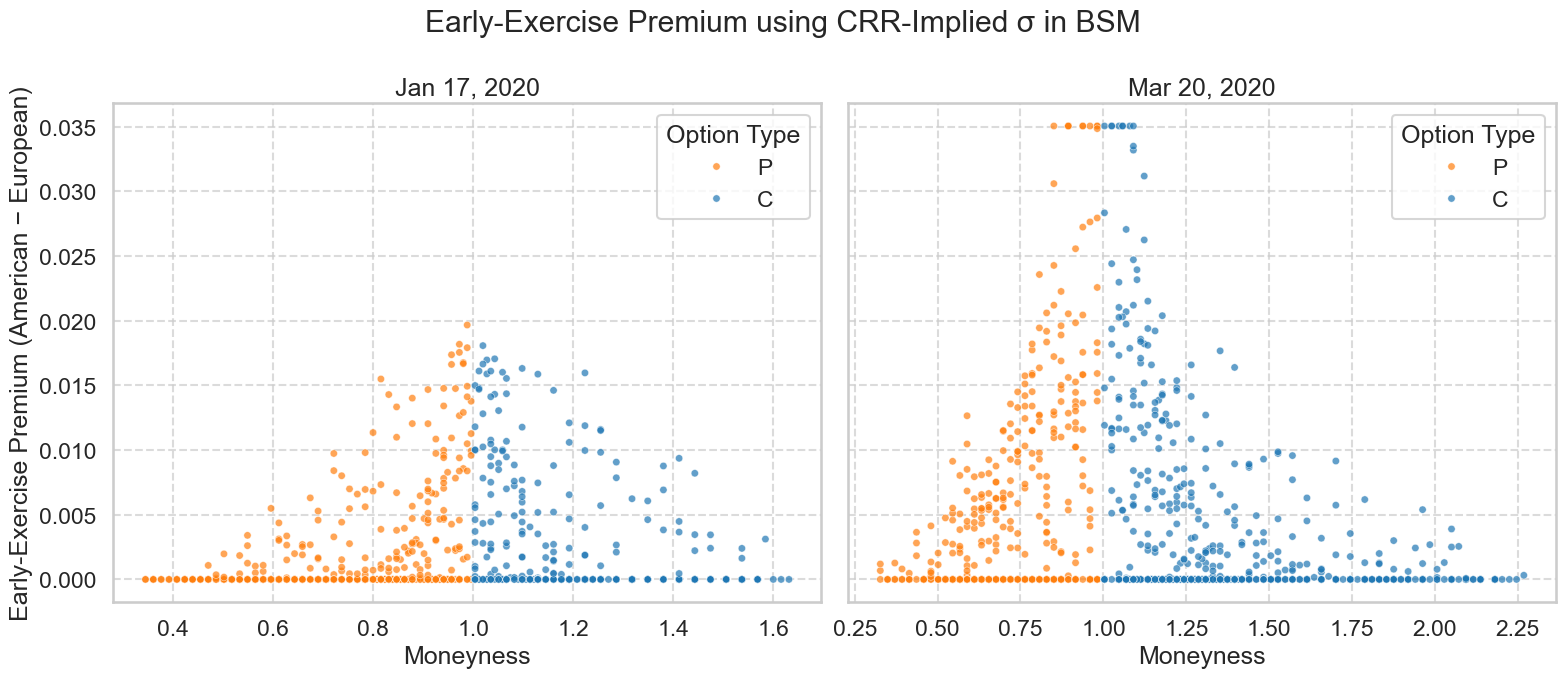

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- Black-Scholes with continuous dividend yield (European) ---
def bsm_price(S, K, T, r, q, sigma, cp_flag):
    if T <= 0:
        return max(0.0, (S-K) if cp_flag == "C" else (K-S))
    if sigma is None or np.isnan(sigma) or sigma <= 0:
        F = S * np.exp((r - q) * T)
        intrinsic_fwd = max(0.0, F - K) if cp_flag == "C" else max(0.0, K - F)
        return np.exp(-r * T) * intrinsic_fwd

    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    if cp_flag == "C":
        return S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)

# --- convenience/dividend yield y from S vs S_exdiv ---
def add_div_yield(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    has_S = "stock_price" in d.columns
    S  = d["stock_price"].astype(float) if has_S else d["stock_exdiv"].astype(float)
    Sx = d["stock_exdiv"].astype(float)
    T  = d["YTM"].astype(float)
    # if gross spot available, compute y; else y=0 and we’ll use Sx
    y = np.where(has_S & (T > 0) & (Sx > 0) & (S > 0), np.log(S / Sx) / T, 0.0)
    d["div_yield"] = np.maximum(y, 0.0)
    d["S_used"]    = S if has_S else Sx  # consistent spot for pricing & moneyness
    d["q_used"]    = d["div_yield"] if has_S else 0.0
    return d

# --- European price using BSM with consistent (S_used, q_used, iv_crr) ---
def compute_euro_equivalent(df):
    d = df.copy()
    d["cp_flag"] = d["cp_flag"].astype(str).str.upper().str[0]
    d["euro_equiv"] = [
        bsm_price(S=float(S), K=float(K), T=float(T), r=float(r), q=float(q),
                  sigma=float(sig) if pd.notna(sig) else np.nan, cp_flag=cp)
        for S, K, T, r, q, sig, cp in zip(
            d["S_used"], d["strike"], d["YTM"], d["risk_free"], d["q_used"],
            d["iv_crr"], d["cp_flag"]
        )
    ]
    # Economic cap: European ≤ observed American
    d["euro_equiv"] = np.minimum(d["euro_equiv"], d["option_price"])
    return d

# ---------- pipeline ----------
df = options.copy()
need = ["date","exdate","cp_flag","strike","stock_exdiv","YTM","risk_free","option_price","iv_crr"]
df = df.dropna(subset=[c for c in need if c in df.columns])

for c in ["date","exdate"]:
    df[c] = pd.to_datetime(df[c]).dt.tz_localize(None).dt.normalize()

df = add_div_yield(df)
df = compute_euro_equivalent(df)

# Early-exercise value (non-negative by definition)
df["early_ex_premium"] = np.maximum(0.0, df["option_price"] - df["euro_equiv"])

# Consistent moneyness with the spot used in pricing
df["moneyness"] = df["strike"] / df["S_used"]

# Optional: OTM in this (simple) space
df = df[((df["cp_flag"]=="C") & (df["moneyness"]>1.0)) |
        ((df["cp_flag"]=="P") & (df["moneyness"]<=1.0))]

# Clip for readability
df["early_ex_premium_plot"] = df["early_ex_premium"].clip(lower=0, upper=np.nanpercentile(df["early_ex_premium"], 99))

# Labels
label_map = {pd.Timestamp("2020-01-17"): "Jan 17, 2020", pd.Timestamp("2020-03-20"): "Mar 20, 2020"}
df["quote_date"] = df["date"].map(label_map)

# ---------- plot ----------
sns.set_context("talk"); sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

for ax, qd in zip(axes, ["Jan 17, 2020", "Mar 20, 2020"]):
    sub = df[df["quote_date"] == qd]
    sns.scatterplot(
        data=sub, x="moneyness", y="early_ex_premium_plot",
        hue="cp_flag", palette={"C":"tab:blue","P":"tab:orange"},
        alpha=0.7, s=28, ax=ax
    )
    ax.set_title(qd)
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("Early-Exercise Premium (American − European)" if qd=="Jan 17, 2020" else "")
    ax.grid(True, linestyle="--", alpha=0.7)
    if ax.legend_:
        ax.legend_.set_title("Option Type")

fig.suptitle("Early-Exercise Premium using CRR-Implied σ in BSM")
plt.tight_layout()
plt.show()


# Question 7

Muravyev, Pearson and Pollet (2022), suggest that we can use put-call parity to infer borrow fees on stocks. Let $\tilde{h}_t$ be the borrow fee at time $t$. An investor who buy the stock at $S_t$ can lend the stock and receive $\tilde{h}_tS_t$ at time $t+1$.

We can estimate the implied borrow fee from the option prices under Q measure: $\tilde{h}_{t}^{\mathbb{Q}}$. The put-call parity relation including one-day borrow fee is
\begin{equation*}
\hat{S}_t - S_t \left(1 - (1 - e^{-r(T-t)} \tilde{h}_{t}^{\mathbb{Q}})^D \right) = c_t - p_t + e^{-r(T-t)}K
\end{equation*}
where $D$ is the number of days to maturity. Consequently, the one-day borrow fee is:
\begin{equation*}
\tilde{h}_{t}^{\mathbb{Q}} = e^{r(T-t)} \left[1 - \left(1 - \frac{1}{S_t} (\hat{S}_t - c_t + p_t - e^{-r(T-t)} K) \right)^{1/D} \right]
\end{equation*}

Unfortunately, whereas put-call parity applies only to European options, options on individual equities are typically American. However, Muravyev, Pearson and Pollet (2025) suggest that, using a CRR implied volatility for American options, one can use the difference in 1-month ATM implied volatility of puts and calls in to compute an approximation to the 
<span style="background:#ffe6e6;color:#8b0000;padding:2px 4px;border-radius:3px;">annualized borrow fee</span>, which is
\begin{equation*}
h_t^{\mathbb{Q}} \approx -(\sigma_c - \sigma_p) / \sqrt{2\pi (T-t)},
\end{equation*}
Compute this approximation on both dates in the sample and discuss your results.